In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# 1. Load your pre-trained model (replace this with your model path)
pretrained_model_path = 'asl_cnn_model.h5'  # Your pre-trained model file
model = load_model(pretrained_model_path)

# 2. Unfreeze layers for fine-tuning
# Optionally, you can unfreeze specific layers, but here we're unfreezing all layers
for layer in model.layers:
    layer.trainable = True  # Unfreeze all layers

# 3. Set up data augmentation and preprocessing using ImageDataGenerator
train_data_dir = r"E:\ASL_Alphabet_Dataset\asl_alphabet_train_processed"  # Replace with the path to your training images

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into training and validation sets
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Path to your training data
    target_size=(64, 64),  # Resize images to match input size of the model
    batch_size=64,
    class_mode='categorical',  # Categorical for multi-class classification
    subset='training'  # Use this subset for training
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Same directory, using a different subset for validation
    target_size=(64, 64),  # Resize images to match input size of the model
    batch_size=64,
    class_mode='categorical',  # Categorical for multi-class classification
    subset='validation'  # Use this subset for validation
)

# 4. Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Print model summary to see the architecture and confirm changes
model.summary()

# 6. Define callbacks to monitor and adjust training process
callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=2, cooldown=0),
    EarlyStopping(monitor='accuracy', patience=2, min_delta=1e-4)
]

# 7. Fine-tune the model (retrain the entire model or only some layers)
hist = model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=callbacks
)

# 8. Save the fine-tuned model
model.save('asl_cnn_model_finetuned.h5')

# 9. Evaluate the fine-tuned model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Found 142694 images belonging to 29 classes.
Found 35660 images belonging to 29 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 29)                  │         118,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,660,253 (6.33 MB)

 Trainable params: 1,660,253 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 616s 275ms/step - accuracy: 0.3449 - loss: 2.4621 - val_accuracy: 0.7792 - val_loss: 0.8838 - learning_rate: 1.0000e-04
Epoch 2/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 596s 267ms/step - accuracy: 0.7489 - loss: 0.8370 - val_accuracy: 0.8379 - val_loss: 0.6028 - learning_rate: 1.0000e-04
Epoch 3/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 583s 261ms/step - accuracy: 0.8237 - loss: 0.5808 - val_accuracy: 0.8567 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 4/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 578s 259ms/step - accuracy: 0.8628 - loss: 0.4543 - val_accuracy: 0.8607 - val_loss: 0.5167 - learning_rate: 1.0000e-04
Epoch 5/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 575s 258ms/step - accuracy: 0.8823 - loss: 0.3824 - val_accuracy: 0.8726 - val_loss: 0.4719 - learning_rate: 1.0000e-04
Epoch 6/10
2230/2230 ━━━━━━━━━━━━━━━━━━━━ 580s 260ms/step - accuracy: 0.9007 - loss: 0.3255 - val_accuracy: 0.8805 - val_loss: 0.4445 - learning_rate: 1.0000e-04
Epoch 7/10
2230/2230 ━━━━━━━

558/558 ━━━━━━━━━━━━━━━━━━━━ 90s 161ms/step - accuracy: 0.8948 - loss: 0.4058
Validation Loss: 0.41486656665802, Validation Accuracy: 0.8922882676124573


In [2]:
model.save("asl_cnn_model_finetuned.keras") 
print("Model saved as 'asl_cnn_model.keras'")

Model saved as 'asl_cnn_model.keras'


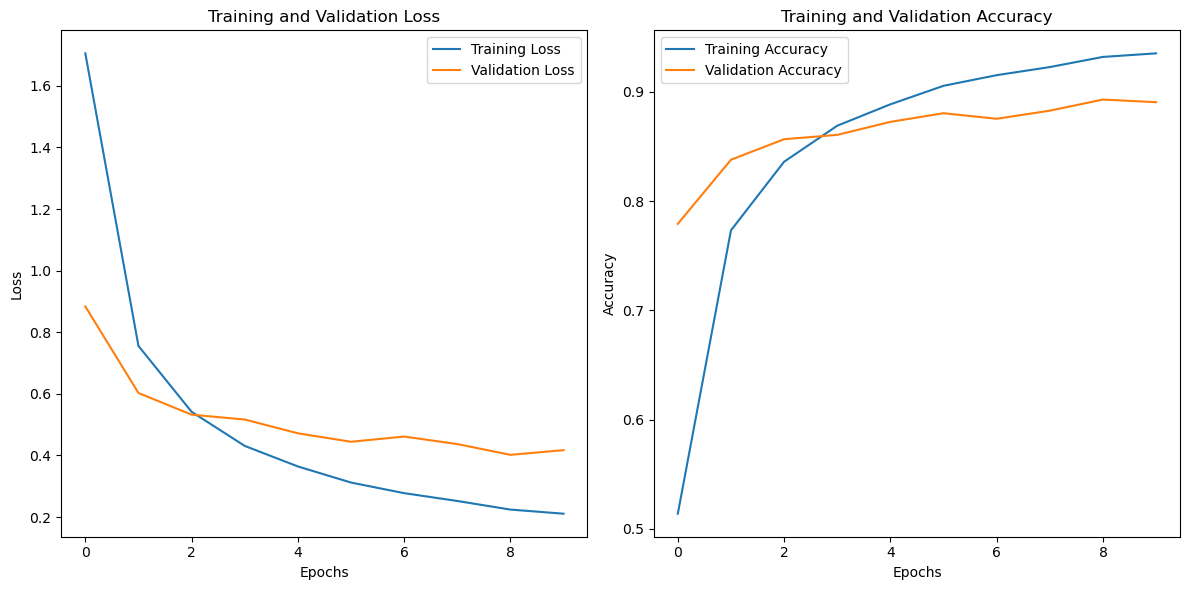

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()